# Librerias

In [1]:
# Import functions from py scripts
from basic_functions import *
from bathymetry_functions import *

# Import librerias from python
import matplotlib as mpl
import datetime
import glob
import os
import matplotlib.dates as mdates
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import matplotlib.pylab as pl
from scipy import signal
from pytz import timezone
import pytz
import missingno as msno
from netCDF4 import Dataset, num2date
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import calendar

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_wave_era5(path):
    """
    Esta función lee los datos de los netcdf de las olas 
    - path: ruta donde se encuentra almacenado el archivo
    - file_name: nombre del archivo
    """
    data = Dataset(f'{path}','r')
    lat_wave = np.array(data.variables['latitude'][:]);
    lon_wave = np.array(data.variables['longitude'][:]);
    nctime_wave = np.array(data.variables['time'][:]);
    t_unit_wave = data.variables['time'].units;
    t_cal_wave = data.variables['time'].calendar;
    time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave);#Date time
    hs = np.array(data.variables['swh'][:]);
    tp = np.array(data.variables['pp1d'][:]);
    direc = np.array(data.variables['mwd'][:]);
    # Cambiar la zona horaria utc 0 a utc -5
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    # col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time_wave = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    dic_wave = {'time': time_wave, 'lon': lon_wave, 'lat':lat_wave ,'Hs': hs, 'Tp': tp, 'Direc': direc}
    # dic_wave = {'Hs': hs, 'Tp': tp, 'Direc': direc}

    return dic_wave



def plot_cells_data_base (variable:str ,lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - variable: Nombre de la variable que se esta analizando
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle(f'Localización de los pixeles {variable}',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)

# Plotear los pixeles

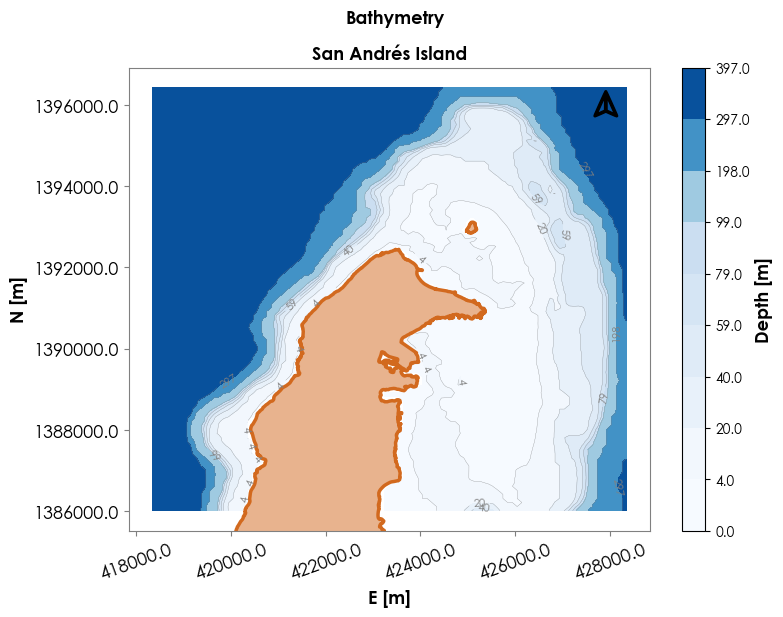

In [3]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line(path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

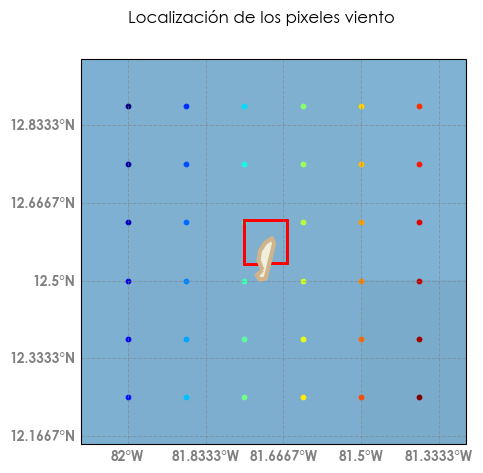

In [4]:
paths_wave = sorted(glob.glob(r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_ERA5\Data_Wave\*.nc"))
dic_wave = read_wave_era5(path = paths_wave[0])
lat = dic_wave['lat'] # Para iniciar de abajo hacia arriba
lon = dic_wave['lon']
plot_cells_data_base (variable = 'viento', lon = dic_wave['lon'] , lat = dic_wave['lat'], plot_dfbat = True, df_bat = df_bat_sai)

# Sacar los promedios por mes y por hora 

In [5]:
def mean_horly_pixel(lat:float, lon:float, paths:list):
    dic_data = {}
    for i, path in enumerate(paths):
        dic_pathi = read_wave_era5(path=path)
        lat_serie = dic_pathi['lat'] # Para iniciar de abajo hacia arriba
        lon_serie = dic_pathi['lon']
        ind_lat = np.where(lat_serie == lat )[0][0]
        ind_lon = np.where(lon_serie == lon )[0][0]
        df_pathi = pd.DataFrame({'time':dic_pathi['time'], 
                                'Hs':dic_pathi['Hs'][:,ind_lat, ind_lon], 'Tp':dic_pathi['Tp'][:,ind_lat, ind_lon], 
                                'Direc':dic_pathi['Direc'][:,ind_lat, ind_lon]})
        dic_data.update({i:df_pathi})
    
    df_pixel = pd.concat(dic_data, ignore_index=True)


    df_grouped = df_pixel.groupby([df_pixel['time'].dt.month, df_pixel['time'].dt.day, df_pixel['time'].dt.hour]).mean()
    df_grouped.index.set_names(['month', 'day', 'hour'], level=[0,1,2], inplace=True)
    df_grouped = df_grouped.reset_index()

    df_grouped['year'] = list(map(lambda x: int(x), np.ones(len(df_grouped))*2000))
    df_grouped['time'] = pd.to_datetime(df_grouped[['year','month', 'day','hour']], format=format).dt.strftime('%m-%d %H')
    df_grouped.set_index('time', inplace=True)
    df_grouped = df_grouped.iloc[:,:-1]

    return df_grouped


def func_dic_data_pixels (lat:np.array, lon:np.array, paths:list):
    dic_db = {}
    k = 0 
    for j in range(len(lat)):
        for i in range(len(lon)):
            df_pixel_i = mean_horly_pixel(lat = lat[j], lon= lon[i], paths= paths)
            dic_db.update({k:df_pixel_i})
            k = k+1
    return dic_db

In [7]:
# Hacer los promedios de los datos 
dic_pixels = func_dic_data_pixels(lat = lat, lon= lon,  paths= paths_wave)

# Estrcuturar los campos de las variables
dic_mean_data = {}
months_names = calendar.month_name[1:]
for month, month_str in zip(range(1,13,1), months_names):
    print(month, month_str)
    df_0 = dic_pixels[0][dic_pixels[0]['month']==month]
    df_0.reset_index(drop=True, inplace=True)
    df_0['year'] = list(map(lambda x: int(x), np.ones(len(df_0))*2020))
    # time = pd.to_datetime(df_0[['year','month', 'day','hour']])
    time  =np.array(list(map(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%S:%M'), pd.to_datetime(df_0[['year','month', 'day','hour']]))))

    Hs = np.ones(shape =(len(df_0), len(lat), len(lon)))
    Tp = np.ones(shape =(len(df_0), len(lat), len(lon)))
    Direc = np.ones(shape =(len(df_0), len(lat), len(lon)))

    k = 0 
    for i in range(len(lat)):
        for j in range(len(lon)):
            df = dic_pixels[k][dic_pixels[k]['month'] == month][['Hs', 'Tp', 'Direc']]
            Hs[:, i, j] = df['Hs'].values
            Tp[:, i, j] = df['Tp'].values
            Direc[:, i, j] = df['Direc'].values
            k = k+1

    dic_mean_data.update({month_str:{'time':time, 'Hs': Hs, 'Tp':Tp, 'Direc': Direc}})

1 January
2 February
3 March
4 April
5 May
6 June
7 July
8 August
9 September
10 October
11 November
12 December


# Guardar los TPAR para SWAN

In [8]:
def TEPAR_files_swan(path:str, filename:str ,lon:float, lat:float, Latitud:np.array, Longitud:np.array, dic_wave:dict , date_ini:datetime.datetime, date_fin:datetime.datetime): 
    """Este archivo genera y guarda el archivo TPAR del modelo SWAN o Delf-3D

    Parameters
    ----------
    path : str
        Ruta donde se almacenará el archivo
    filename : str
        Nombre del archivo
    lon : float
        longitud del pixel donde se extrae la información 
    lat : float
        latitud del pixel donde se extrae la información 
    Latitud : np.array
        Arreglo de las latitudes del campo de las variables
    Longitud : np.array
        Arreglo de las longitudes del campo de las variables
    dic_wave : dict
        Diccionario donde se encuentran las variables
    date_ini : datetime.datetime
        fecha incial de almacenamiento de datos en el archivo
    date_fin : datetime.datetime
        fecha final de almacenamiento de datos del archivo

    Returns
    -------
    pd.DataFrame
        df_data: data frame de los parametros del oleaje
    """

    time_wave = dic_wave['time']
    hs = dic_wave['Hs']
    tp = dic_wave['Tp']
    direc = dic_wave['Direc']


    in_lat = np.where((Latitud == lat))[0]
    in_lon = np.where((Longitud == lon))[0]
    ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
    
    time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
    str_time_wave =[time_d3d_wave[i].strftime("%Y%m%d.%H%M") for i in range( len(time_d3d_wave))]
    Hs = hs[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Hs = [Hs[i][0] for i in range(len(Hs))]
    Tp = tp[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Tp = [Tp[i][0] for i in range(len(Tp))]
    Direc = direc[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Direc = [Direc[i][0] for i in range(len(Direc))]
    Des_direc = list(np.ones(shape=len(Direc))*40)
    Dir_Param = {'Time':str_time_wave, 'Hs': Hs, 'Tp': Tp, 'Direc': Direc, 'Des_Dirc': Des_direc}
    df_data = pd.DataFrame(data = Dir_Param)
    with open (f'{path}\{filename}.bnd', "w") as f:
        f.write("TPAR \n")
        np.savetxt(f,df_data,fmt =('%s  %7.9f  %8.9f  %9.9f  %5.1f'))
    return df_data

def fun_save_wave_month_file(month:str, imonth:int, date_ini:datetime.datetime, date_fin:datetime.datetime, lon:float, lat:float, Latitud:np.array, Longitud:np.array, dic_wave_month:dict, path:str, file_name_out:str):
    """Esta función guarda los archivos tpar en la carpeta del mes indicado

    Parameters
    ----------
    month : str
        mes donde se almacena el archivo
    imonth : int
        indice del mes donde se almacena el archvio 
    date_ini : datetime.datetime
        fecha incial de almacenamiento de datos en el archivo
    date_fin : datetime.datetime
        fecha final de almacenamiento de datos del archivo
    lon : float
        longitud del pixel donde se extrae la información 
    lat : float
        latitud del pixel donde se extrae la información 
    Latitud : np.array
        Arreglo de las latitudes del campo de las variables
    Longitud : np.array
        Arreglo de las longitudes del campo de las variables
    dic_wave_month : dict
        Diccionario donde se encuentran las variables de acuerdo al mes
    path : str
        Ruta donde se almacenará el archivo
    file_name_out : str
        Nombre del archivo
    """

    import os
    if imonth< 10:
        name_folder = f'0{imonth}_{month}'
    else: 
        name_folder = f'{imonth}_{month}'
    
    path_folder = f"{path}\{name_folder}"
    if not os.path.exists(path_folder):
        os.makedirs(path_folder)
        
    TEPAR_files_swan(path= path_folder, filename= file_name_out,
                    lon=lon, lat=lat, Latitud=Latitud, Longitud= Longitud, 
                    dic_wave = dic_wave_month  , date_ini=date_ini, date_fin=date_fin)

In [15]:
path = r'C:\Users\paula\Desktop\CLIMATOLOGIA_SWAN\INPUT_SWAN'
for imonth, month_str in zip (range(1,13,1), list(dic_mean_data.keys())):
    print(imonth, month_str)
    date_ini = datetime.datetime(2020,imonth, 10, 1, 0)
    date_fin = datetime.datetime(2020,imonth, 29, 1, 0)
    dic_wave_month = dic_mean_data[month_str]

    # Note:
    Boundary = 'Norte'
    longitudes = [278.125,278.250, 278.375, 278.5]
    lat_ = 12.750
    for i, lon_ in enumerate(longitudes):
        file_name_ouput = f'TPAR_{Boundary}_{i+1}'
        fun_save_wave_month_file(month = month_str, imonth = imonth, date_ini= date_ini, date_fin = date_fin,
                         lon =lon_ , lat =lat_, Latitud = lat, Longitud = lon, 
                         dic_wave_month = dic_wave_month, path = path, file_name_out = file_name_ouput)

    # Sur
    Boundary = 'Sur'
    longitudes = [278.125,278.250, 278.375, 278.5]
    lat_ = 12.375
    for i, lon_ in enumerate(longitudes):
        file_name_ouput = f'TPAR_{Boundary}_{i+1}'
        fun_save_wave_month_file(month = month_str, imonth = imonth, date_ini= date_ini, date_fin = date_fin,
                         lon =lon_ , lat =lat_, Latitud = lat, Longitud = lon, 
                         dic_wave_month = dic_wave_month, path = path, file_name_out = file_name_ouput)
    
    # Oeste
    Boundary = 'Oeste'
    latitudes = [12.375, 12.5, 12.625, 12.750]
    lon_ = 278.5
    for i, lat_ in enumerate(latitudes):
        file_name_ouput = f'TPAR_{Boundary}_{i+1}'
        fun_save_wave_month_file(month = month_str, imonth = imonth, date_ini= date_ini, date_fin = date_fin,
                         lon =lon_ , lat =lat_, Latitud = lat, Longitud = lon, 
                         dic_wave_month = dic_wave_month, path = path, file_name_out = file_name_ouput)  

    # Este:
    Boundary = 'Este'
    latitudes = [12.375, 12.5, 12.625, 12.750]
    lon_ = 278.125
    for i, lat_ in enumerate(latitudes):
        file_name_ouput = f'TPAR_{Boundary}_{i+1}'
        fun_save_wave_month_file(month = month_str, imonth = imonth, date_ini= date_ini, date_fin = date_fin,
                         lon =lon_ , lat =lat_, Latitud = lat, Longitud = lon, 
                         dic_wave_month = dic_wave_month, path = path, file_name_out = file_name_ouput)          

1 January
2 February
3 March
4 April
5 May
6 June
7 July
8 August
9 September
10 October
11 November
12 December
